## CWRU Data Analytics
**Unit 10 | Assignment - Surf's Up!**

Robert Wood  
4/20/2019

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [235]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Preview table structure for 'measurement'

# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [174]:
# View formatting of data for 'measurement'
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [173]:
# Preview table structure for 'station'

# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [176]:
# View formatting of data for 'station'
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# View date range of available data
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Date range available is {earliest} to {latest}.")

Date range available is ('2010-01-01',) to ('2017-08-23',).


In [246]:
# query_date = dt.date(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
# query_date

result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
query_date = datetime.strptime(result,'%Y-%m-%d')
query_date

datetime.datetime(2017, 8, 23, 0, 0)

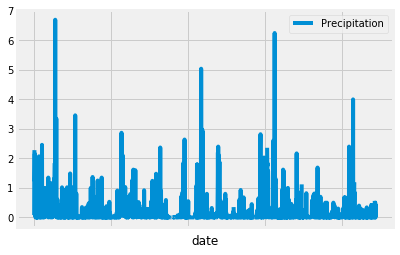

In [247]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago = query_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date', 'Precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x_compat=True)

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
# Design a query to show how many stations are available in this dataset?

# # Query the full Measurement table
# full_table = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
#     filter(Measurement.date > year_ago).\
#     filter(Measurement.date <= query_date).\
#     order_by(Measurement.date).all()

# # Create a DataFrame
# df = pd.DataFrame(full_table, columns=['id', 'station', 'date', 'prcp', 'tobs'])

# # Display DataFrame summary
# df.head()

session.query(Station).distinct(Station.id).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).count()

9

In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [79]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

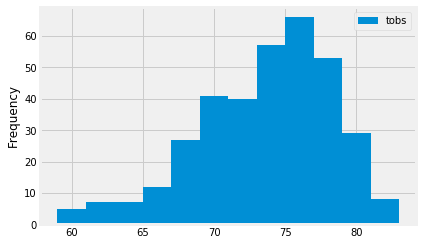

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query one year of data from the station, save results to a list
tobs_table = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).all()

# Create a DataFrame
tobs_df = pd.DataFrame(tobs_table, columns=['tobs'])

# Plot Histogram
tobs_df.plot.hist(bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# calc_temps(year_ago,query_date)
# calc_temps('2016-08-23', '2017-08-23')
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

([], <a list of 0 Text xticklabel objects>)

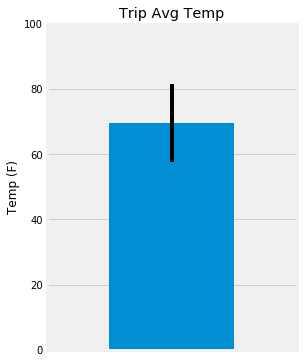

In [179]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_list = calc_temps('2012-02-28', '2012-03-05')

# plt.bar(0,temp_list[0][1],yerr=temp_list[0][2]-temp_list[0][0],color='lightcoral',alpha=.5)
# # plt.title('Trip Avg Temp')
# plt.ylabel('Temp (F)')

temp_df = pd.DataFrame(temp_list, columns=['min','avg','max'])
temp_df.plot.bar(y='avg',title="Trip Avg Temp",yerr=temp_df['max']-temp_df['min'],legend=False,figsize=(4,6))
plt.ylabel("Temp (F)")
plt.yticks([0,20,40,60,80,100])
plt.xticks([])
# plt.show()

In [265]:
# station fields:
# id INTEGER
# station TEXT
# name TEXT
# latitude FLOAT
# longitude FLOAT
# elevation FLOAT
start_date = '2012-02-28'
end_date = '2012-03-05'

results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for result in results:
    print(f"Station: {result[0]}\n"
          f"Name: {result[1]}\n"
          f"Lat/Lng: {'{:.2f}'.format(result[2])}, {'{:.2f}'.format(result[3])}\n"
          f"Elevation: {result[4]} m\n"
          f"Precipitation: {'{:.2f}'.format(result[5])} cm\n")

Station: USC00519281
Name: WAIHEE 837.5, HI US
Lat/Lng: 21.45, -157.85
Elevation: 32.9 m
Precipitation: 11.08 cm

Station: USC00516128
Name: MANOA LYON ARBO 785.2, HI US
Lat/Lng: 21.33, -157.80
Elevation: 152.4 m
Precipitation: 10.32 cm

Station: USC00513117
Name: KANEOHE 838.1, HI US
Lat/Lng: 21.42, -157.80
Elevation: 14.6 m
Precipitation: 5.79 cm

Station: USC00518838
Name: UPPER WAHIAWA 874.3, HI US
Lat/Lng: 21.50, -158.01
Elevation: 306.6 m
Precipitation: 3.84 cm

Station: USC00519523
Name: WAIMANALO EXPERIMENTAL FARM, HI US
Lat/Lng: 21.34, -157.71
Elevation: 19.5 m
Precipitation: 2.92 cm

Station: USC00519397
Name: WAIKIKI 717.2, HI US
Lat/Lng: 21.27, -157.82
Elevation: 3.0 m
Precipitation: 1.18 cm

Station: USC00511918
Name: HONOLULU OBSERVATORY 702.2, HI US
Lat/Lng: 21.32, -158.00
Elevation: 0.9 m
Precipitation: 0.76 cm

Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Lat/Lng: 21.52, -157.84
Elevation: 7.0 m
Precipitation: 0.03 cm

Station: USC00517948
Name: PE

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


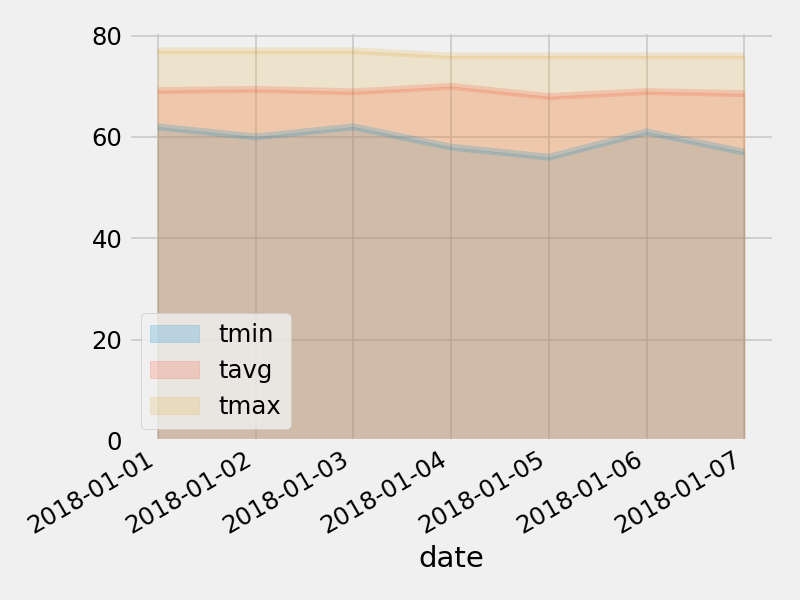

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
